In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Downloading all Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import graphviz
import scipy
# import ggplot

# from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn.tree import export_graphviz
from sklearn.ensemble import forest
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *
# from concurrent.futures import ProcessPoolExecutor

from sklearn import metrics

C:\Users\DELL\Anaconda3\envs\THINAM\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


### Loading the Dataset

In [3]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None, prepoc_fn=None, max_n_cat=None,
           subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset:
        df = get_sample(df, subset)
    else:
        df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if prepoc_fn: prepoc_fn(df)
    if y_fld is None: y=None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    
    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n, c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n, c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [4]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict): 
            df[name + '_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [5]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

In [6]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [7]:
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n))

In [8]:
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n_samples))

In [9]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [10]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
          rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train),
          m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [11]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s = export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                       special_characters=True, rotate=True, precision=precision)
    display(graphviz.Source(re.sub('Tree {',
                                  f'Tree {{ size={size}; ratio={ratio}', s)))

In [12]:
PATH = "C:\\Users\\DELL\\Blue Book for Bulldozers\\Train.csv"
df_raw = pd.read_feather('tmp/raw')

In [13]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [14]:
n_valid = 12000
n_trn = len(df_trn) - n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [15]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

### Random Forest @ Tree Ensemble

In [16]:
class TreeEnsemble():
    
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x = x
        self.y = y
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
    
    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
    
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [17]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x, self.y = x, y
        self.idxs =idxs
        self.min_leaf = min_leaf

In [18]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [19]:
m.trees[0]

In [20]:
class DecisionTree():
    
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None:
            idxs = np.arange(len(y))
        self.x, self.y = x, y
        self.idxs =idxs
        self.min_leaf = min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c):
            self.find_better_split(i)
            
    def find_better_split(self, var_idx):
        pass
    
    @property
    def split_name(self):
        return self.x.columns[self.var_idx]
    
    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]
    
    @property
    def is_leaf(self):
        return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val: {self.val}'
        if not self.is_leaf:
            s += f'; score: {self.score}; split: {self.split}; var: {self.split_name}'
        return s
        
        

In [21]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [22]:
m.trees[0]

n: 1000; val: 10.079014121552744

In [23]:
m.trees[0].idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### Best Split Variable

In [24]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp, y_samp = tree.x, tree.y

In [25]:
x_samp.columns, tree

(Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object'),
 n: 1000; val: 10.079014121552744)

In [26]:
# m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
# m.fit(x_samp, y_samp)
# draw_tree(m.estimators_[0], x_samp, precision=2)

In [27]:
def find_better_split(self, var_idx):
    x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
    
    for i in range(1, self.n-1):
        lhs = x<=x[i]
        rhs = x>x[i]
        if rhs.sum() == 0: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        if curr_score<self.score:
            self.var_idx, self.score, self.split = var_idx, curr_score, x[i]

In [28]:
%timeit find_better_split(tree, 1)
tree

147 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val: 10.079014121552744; score: 681.0184057251435; split: 3744.0; var: MachineHoursCurrentMeter

In [29]:
find_better_split(tree, 0)
tree

n: 1000; val: 10.079014121552744; score: 658.5510186055949; split: 1974.0; var: YearMade

Modifying the above function to increase the computational speed.

In [30]:
def std_agg(cnt, s1, s2):
    return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split_foo(self, var_idx):
    x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y, sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.
    
    for i in range(0, self.n-self.min_leaf-1):
        xi, yi = sort_x[i], sort_y[i]
        lhs_cnt += 1
        rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i < self.min_leaf-1 or xi == sort_x[i+1]:
            continue
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score:
            self.var_idx, self.score, self.split = var_idx, curr_score, xi

In [31]:
%timeit find_better_split(tree, 0)
tree

157 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val: 10.079014121552744; score: 658.5510186055949; split: 1974.0; var: YearMade

In [32]:
find_better_split(tree, 1);tree

n: 1000; val: 10.079014121552744; score: 658.5510186055949; split: 1974.0; var: YearMade

In [33]:
DecisionTree.find_better_split = find_better_split_foo

In [34]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]
tree

n: 1000; val: 10.079014121552744; score: 658.5510186055565; split: 1974.0; var: YearMade

### Building Full Single Tree

In [41]:
def find_varsplit(self):
    for i in range(self.c):
        self.find_better_split(i)
    if self.is_leaf:
        return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [42]:
DecisionTree.find_varsplit = find_varsplit

In [43]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]
tree

n: 1000; val: 10.079014121552744; score: 658.5510186055565; split: 1974.0; var: YearMade

In [44]:
tree.lhs

n: 159; val: 9.660892662981706; score: 76.82696888346362; split: 2800.0; var: MachineHoursCurrentMeter

In [45]:
tree.rhs

n: 841; val: 10.158064432982941; score: 571.4803525045031; split: 2005.0; var: YearMade

In [46]:
tree.lhs.lhs

n: 150; val: 9.619280538108496; score: 71.15906938383463; split: 1000.0; var: YearMade

In [47]:
tree.rhs.rhs

n: 28; val: 10.669849650935848; score: 16.460871194578985; split: 895.0; var: MachineHoursCurrentMeter

### Predictions

In [48]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter',
       'ProductSize', 'Enclosure', 'Coupler_System', 'saleYear']

In [50]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp, y_samp = tree.x, tree.y

Wall time: 787 ms


In [53]:
def predict(self, x):
    return np.array([self.product_row(xi) for xi in x])

DecisionTree.predict = predict

In [54]:
def product_row(self, xi):
    if self.is_leaf:
        return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.product_row(xi)

DecisionTree.product_row = product_row

In [55]:
%time preds = tree.predict(X_valid[cols].values)

Wall time: 196 ms


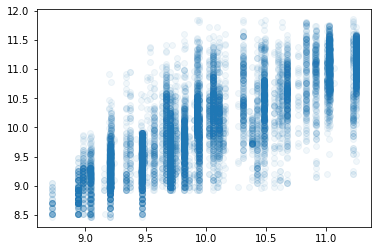

In [56]:
plt.scatter(preds, y_valid, alpha=0.06)

In [57]:
metrics.r2_score(preds, y_valid)

0.5256914970168851

Wall time: 30.6 ms


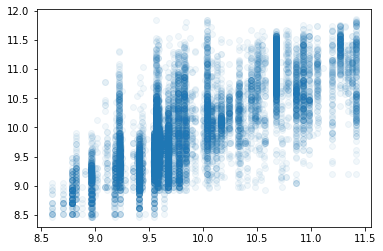

In [58]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=3, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.06)

In [59]:
metrics.r2_score(preds, y_valid)

0.36380555277115534

### Final Model for TreeEnsemble @ RandomForest

In [60]:
class TreeEnsemble():
    
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x = x
        self.y = y
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
    
    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
    
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2):
    return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [61]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None:
            idxs = np.arange(len(y))
        self.x, self.y = x, y
        self.idxs =idxs
        self.min_leaf = min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c):
            self.find_better_split(i)
        if self.is_leaf:
            return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
        
        
            
    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
    
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.
    
        for i in range(0, self.n-self.min_leaf-1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i < self.min_leaf-1 or xi == sort_x[i+1]:
                continue
            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi
    
    @property
    def split_name(self):
        return self.x.columns[self.var_idx]
    
    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]
    
    @property
    def is_leaf(self):
        return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val: {self.val}'
        if not self.is_leaf:
            s += f'; score: {self.score}; split: {self.split}; var: {self.split_name}'
        return s
    
    def predict(self, x):
        return np.array([self.product_row(xi) for xi in x])
    
    def product_row(self, xi):
        if self.is_leaf:
            return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.product_row(xi)

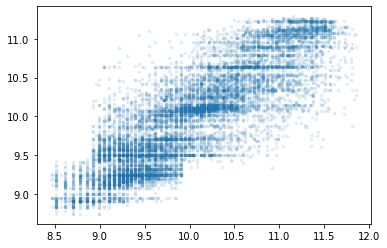

In [62]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)
preds = ens.predict(X_valid[cols].values)
plt.scatter(y_valid, preds, alpha=0.1, s=6)

In [63]:
metrics.r2_score(y_valid, preds)

0.708475323774292

In [64]:
%load_ext cython